### Setup

In [4]:
!pip install -q datasets


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
from datasets import load_dataset_builder
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import time

%matplotlib inline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1754289009.890537      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [6]:
try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Using Tpu")
except:
    if tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print("Using CPU")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1754289028.902635      10 service.cc:148] XLA service 0x56a25881e500 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754289028.902676      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1754289028.902681      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1754289028.902684      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1754289028.902687      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1754289028.902689      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1754289028.902692      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1754289028.902694      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1754289028.902697      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

### Download the dataset

In [7]:
dataset_path = "9wimu9/ada_derana_sinhala"
ds_builder = load_dataset_builder(dataset_path)

In [8]:
print(ds_builder.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('int64'), 'heading': Value('string'), 'content': List(Value('string'))}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='ada_derana_sinhala', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}, download_checksums=None, download_size=159392910, post_processing_size=None, dataset_size=418940569, size_in_bytes=None)


In [9]:
print(ds_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}


In [10]:
from datasets import load_dataset
from pathlib import Path

cache_dir = "./dataset/cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)
dataset = load_dataset(dataset_path, cache_dir=cache_dir)

Generating train split: 100%|██████████| 170420/170420 [00:01<00:00, 145839.16 examples/s]


In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'heading', 'content'],
        num_rows: 170420
    })
})


In [12]:
raw_ds = dataset['train']
print(raw_ds)

Dataset({
    features: ['id', 'heading', 'content'],
    num_rows: 170420
})


### Process the text

In [13]:
content = raw_ds["content"]
print(f"Total number of rows in the raw dataset: {len(content)}")

Total number of rows in the raw dataset: 170420


In [14]:
def create_1d_list(n_d_list: list[list[str]]) -> list[str]:
    one_d_list = []
    for row in n_d_list:
        if len(row) > 1:
            for sub_row in row:
                one_d_list.append(sub_row)
        elif len(row) == 0:
            pass
        else:
            one_d_list.append(row[0])
    return one_d_list

In [15]:
text_list = create_1d_list(content)
print(f"Total number of paragraphs: {len(text_list)}")

Total number of paragraphs: 1048395


In [16]:
def get_value_counts(text: str, decode=False) -> dict:
    chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
    values, counts = np.unique(chars, return_counts=True)
    counts = map(lambda x: int(x), counts)
    if decode:
        values = map(lambda x: x.decode('UTF-8'), values)
    value_counts = dict(zip(values, counts))
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

In [17]:
def clean_text(text: str, replacement: str = "") -> str:
    # lower english characters
    text = text.lower()
    # replace curly double quotes with straight double quotes
    text = re.sub(r"[\u201C\u201D]", "\u0022", text)
    # replace curly single quotes with straight single quotes
    text = re.sub(r"[\u2018\u2019]", "\u0027", text)
    # replace en-dash with dash
    text = re.sub(r"\u2013", "\u002D", text)
    # replace everything outside the allowed pattern with the replacement
    allowed_pattern = r"[a-z0-9\u0D80-\u0DFF\u200C\u200D!@#$%^&*()\[\]{}.,:;'\"<>?/\\|`~=_+ -]"
    cleaned = ''.join(char if re.match(allowed_pattern, char) else replacement for char in text)
    return cleaned

In [18]:
start = time.time()
text = ' '.join(text_list)
cleaned_text = clean_text(text)
end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 127.61001110076904 seconds


In [19]:
print(cleaned_text[0:20000])

ගාල්ල, මාගාල්ල ප්‍ර‍ෙද්ශයේ ඉදිකර තිබූ ජාතික නිදහස් පෙරමුණේ දිස්ත්‍රික් කාර්යාලයට ඊයේ රාත්‍රී කිසියම් පිරිසක් ප්‍රහාරයක් එල්ල කර ති‍‍බේ. ප්‍රහාරය එල්ල කළ පිරිස් විසින් එම කාර්යාලයේ තිබූ බැනර් සහ කටවුට්වලට කළුතෙල් දමා ඇති බව වාර්තා ‍වේ. මේ සම්බන්ධයෙන් ජාතික නිදහස් පෙරමුණ ගාල්ල පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇත. මේ අතර විපක්ෂ‍ෙය් පොදු ‍අපේක්ෂකයා සහභාගී වන රැළියක් වෙනුවෙන් මාතලේ ‍ප්‍රදේශ‍ෙය් සැරසිලි කටයුතුවල නිරතවෙමින් සිටි එක්සත් ජාතික පක්ෂ සහ ජනතා විමුක්ති පෙරමුණු ආධාරකරුවන් පිරිසකට අද අලුයම කිසියම් පිරිසක් පහර දී ති‍‍බේ. ප්‍රහාරයෙන් තුවාල ලැබූ ජනතා විමුක්ති පෙරමුණු සාමාජිකයෙකු ප්‍රතිකාර සඳහා මිහින්තලේ රෝහලට ඇතුළත් කර ඇති බව ද සඳහන් ‍‍‍‍වේ. මේ සම්බන්ධයෙන් මිහින්තලේ පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇති බව වාර්තා‍‍වේ. මෙරට සෞඛ්‍ය ක්ෂේත්‍රය නගා සිටුවීමේ අරමුණින් පළාත් රෝහල් සඳහා නවීන වෛද්‍ය උපකරණ ලබාදීමේ වැඩපිළිවෙළක් සෞඛ්‍ය අමාත්‍යාංශය ආරම්භ කර තිබේ. එම අමාත්‍යාංශය පවසන පරිදි මේ යටතේ රුපියල් ‍කෝටි 250 ක නව වෛද්‍ය උපකරණ පළාත් රෝහල් වෙත ලබා‍දේ. පළාත් රෝහල්වල දැනට ඇති වෛද්‍ය උපකරණ යල් 

In [20]:
all_characters = sorted(set(text))
print(f"unique characters before cleaning: \n{all_characters}\n")
vocab = sorted(set(cleaned_text))
print(f"unique characters after cleaning: \n{vocab}\n")
print(f"vocabulary length: {len(vocab)}")

unique characters before cleaning: 
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¥', 'ª', '«', '\xad', '®', '°', '´', 'µ', '·', '¼', '½', '¿', 'À', 'Á', 'Ç', '×', 'á', 'â', 'ã', 'ä', 'é', 'ê', 'í', 'ñ', 'ó', '÷', 'ø', 'ú', 'ü', 'ā', 'ć', 'ğ', 'İ', 'ı', 'ō', 'Œ', 'ş', 'š', 'ư', 'ɪ', 'ʀ', 'ʙ', 'ʟ', '˜', '˝', '̃', '̈', 'Ω', 'ܻ', 'ं', 'आ', 'उ', 'ए', 'क', 'ग', 'च', 'ज', 'द', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ू', 'े', 'ै', 'ो', 'இ', 'எ', 'ஐ', 'க', 'ச', 'ட', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'வ',

In [21]:
chars = tf.strings.unicode_split(cleaned_text, input_encoding='UTF-8')
print(chars)

tf.Tensor(
[b'\xe0\xb6\x9c' b'\xe0\xb7\x8f' b'\xe0\xb6\xbd' ... b'\xe0\xb6\xba'
 b'\xe0\xb7\x92' b'.'], shape=(148840215,), dtype=string)


In [22]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=vocab, mask_token=None)

In [23]:
input_ids = ids_from_chars(chars)
input_ids

<tf.Tensor: shape=(148840215,), dtype=int64, numpy=array([ 90, 130, 121, ..., 119, 133,  15])>

In [24]:
print(ids_from_chars.get_vocabulary())

['[UNK]', np.str_(' '), np.str_('!'), np.str_('"'), np.str_('#'), np.str_('$'), np.str_('%'), np.str_('&'), np.str_("'"), np.str_('('), np.str_(')'), np.str_('*'), np.str_('+'), np.str_(','), np.str_('-'), np.str_('.'), np.str_('/'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(':'), np.str_(';'), np.str_('<'), np.str_('='), np.str_('>'), np.str_('?'), np.str_('@'), np.str_('['), np.str_('\\'), np.str_(']'), np.str_('^'), np.str_('_'), np.str_('`'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_('{'), np.str_('|'), np.str_('}'), np.str_('~'), np.str_('ං'), np.str_('

In [25]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [26]:
chars = chars_from_ids(input_ids)
chars

<tf.Tensor: shape=(148840215,), dtype=string, numpy=
array([b'\xe0\xb6\x9c', b'\xe0\xb7\x8f', b'\xe0\xb6\xbd', ...,
       b'\xe0\xb6\xba', b'\xe0\xb7\x92', b'.'], dtype=object)>

In [27]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy().decode('UTF-8')

### Create train, val and test sets

In [28]:
seq_length = 200
ids_dataset = tf.data.Dataset.from_tensor_slices(input_ids)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [29]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [30]:
BUFFER_SIZE = 10000
full_dataset = sequences.map(split_input_target)
shuffled_dataset = full_dataset.shuffle(buffer_size=BUFFER_SIZE,
                                        reshuffle_each_iteration=False,
                                        seed=42)

In [31]:
dataset_size = tf.data.experimental.cardinality(sequences).numpy()
train_size = int(0.9 * dataset_size)
val_size = int(0.1 * dataset_size)

In [32]:
train_set = shuffled_dataset.take(train_size)
remaining = shuffled_dataset.skip(train_size)
val_set = remaining.take(val_size)
test_set = remaining.skip(val_size)

In [33]:
for input_example, target_example in train_set.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 
Target:  වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා ම


In [34]:
# To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores)
BATCH_SIZE = 512
train_set = train_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

### Build the model

In [35]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

In [36]:
class GRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                      return_sequences=True,
                                      return_state=True,
                                      reset_after=False)  # Disables CuDNN-specific behavior
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            batch_size = tf.shape(x)[0]
            states = self.gru.get_initial_state(batch_size)
        out = self.gru(x, initial_state=states, training=training)
        x, states = out
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [37]:
model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

In [38]:
for input_example_batch, target_example_batch in train_set.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(512, 200, 150)


In [39]:
model.summary()

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (512, 200, 256)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ((512, 200, 1024),     │     3,935,232 │
│                                 │ (512, 1024))           │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (512, 200, 150)        │       153,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,127,382 (15.74 MB)

 Trainable params: 4,127,382 (15.74 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print(sampled_indices)

[ 74 112 122  65  54  27 122  23   5 129 121  48 101  41 127 106  88 132
  44  19 143 118 135  96 110 131  23  86   5  75  96  55  28   1  64  22
  45  83  26 136  58  41  58   5 129  36 122 126 103 127 121  96  57  98
  38  29 146   6 135  10  72 127 118 147  60  12 122  14  73 121  23  97
  36  77  44 129  72 104 130  81  31  52  78  83  43  11 102  36  93  83
 138 106 101  69 135  36 136  78  65 131  37  65  62  63  87  62 147  34
  64  71  20  93  63  75   6  45  69  62  76  12  84  81  42  62  96 122
 127  70 142 107  59  27  97 122 129  34  30  20  92  11  88  24  99  15
 111 138  29  39  20  17   3 108  64  30  55  99 107  80  38  60  20  62
  37 134 144   1 123  64  92  76  62   9   6 135 124  18  26  17  84 115
  27  66 133 105  21 102 107 133  34  85 124 136  69 135  11  89  97  61
 143   2]


In [41]:
print("input:\n", text_from_ids(input_example_batch[0]))
print()
print("predictions:\n", text_from_ids(sampled_indices))

input:
 ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 

predictions:
 ඇඳවzo:ව6$්ලiටbළඬකෑe2ෞඹුජධැ6ඕ$ඈජp; y5fඒ9ූsbs$්]වහඩළලජrඤ_<ෲ%ු)අළඹෳu+ව-ආල6ඣ]ඊe්අඪාඏ>mඋඒd*ඨ]ඟඒෙඬට~ු]ූඋzැ^zwxඖwෳ[yඃ3ඟxඈ%f~wඉ+ඓඏcwජවළංෝතt:ඣව්[=3ඞ*ක7ඥ.නෙ<`30"ථy=pඥතඍ_u3w^ීෟ ශyඞඉw(%ුෂ190ඓබ:{ිණ4ඨති[ඔෂූ~ු*ඛඣvෞ!


### Train the model

In [42]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [43]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape)
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (512, 200, 150)
Mean loss:         tf.Tensor(5.0095434, shape=(), dtype=float32)


In [44]:
checkpoints_dir = "./training_checkpoints"
Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt_{epoch}.weights.h5")

In [45]:
EPOCHS = 20

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [46]:
with strategy.scope():
    model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=adam, loss=loss)

I0000 00:00:1754289283.058154      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [47]:
history = model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/20


I0000 00:00:1754289297.536384      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6411865025505522233
I0000 00:00:1754289297.818682     985 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2445860659298797420), session_name()
I0000 00:00:1754289299.786080     985 tpu_compile_op_common.cc:245] Compilation of 2445860659298797420 with session name  took 1.96733288s and succeeded
I0000 00:00:1754289299.792168     985 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2445860659298797420), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6411865025505522233", property.function_library_fingerprint = 10076098872150314273, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.2159

I0000 00:00:1754289555.284614      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2996402740689701732
I0000 00:00:1754289555.381342     983 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2295684633380536554), session_name()
I0000 00:00:1754289556.435602     983 tpu_compile_op_common.cc:245] Compilation of 2295684633380536554 with session name  took 1.0541973s and succeeded
I0000 00:00:1754289556.437318     983 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2295684633380536554), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2996402740689701732", property.function_library_fingerprint = 10641916975933383650, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = 

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 402s 305ms/step - loss: 2.2154 - val_loss: 1.0984
Epoch 2/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 406s 310ms/step - loss: 1.0221 - val_loss: 0.9940
Epoch 3/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 408s 311ms/step - loss: 0.9351 - val_loss: 0.9514
Epoch 4/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 400s 305ms/step - loss: 0.8953 - val_loss: 0.9304
Epoch 5/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 405s 309ms/step - loss: 0.8721 - val_loss: 0.9165
Epoch 6/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 417s 318ms/step - loss: 0.8571 - val_loss: 0.9082
Epoch 7/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 407s 311ms/step - loss: 0.8465 - val_loss: 0.9028
Epoch 8/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 403s 307ms/step - loss: 0.8385 - val_loss: 0.8987
Epoch 9/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 394s 300ms/step - loss: 0.8325 - val_loss: 0.8959
Epoch 10/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 407s 310ms/step - loss: 0.8280 - val_loss: 0.8938
Epoch 11/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 405s 309ms/step - loss: 0.8244 - val_loss: 0.89

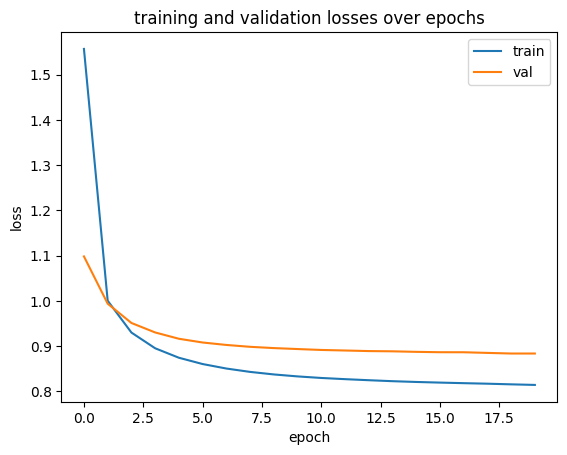

In [48]:
num_epochs = len(history.history["loss"])
plt.plot(range(num_epochs), history.history["loss"], label="train")
plt.plot(range(num_epochs), history.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training and validation losses over epochs")
plt.legend()
plt.show()

### Generate text

In [49]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars):
    super().__init__()
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(values=[-float('inf')]*len(skip_ids), indices=skip_ids, dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None, temperature=1.0):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
    
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/temperature
    
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [50]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [55]:
start = time.time()
states = None
next_char = tf.constant(['ජාතික'])
temperature = tf.constant(1.0)
result = [next_char]

for n in range(10000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states, temperature=temperature)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('UTF-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ජාතිකත්වයට පත්කිරීමට තීරණය කළ බවද වාර්තා වෙනවා. එහෙනම් ඒ පැත්තේ තිබෙන කැපකිරීමක් සිදුවන්නේ නෑ. විශේෂයෙන් මහාචාර්ය පූජ්‍ය මැදගොඩ මෛත්‍රීපාල සිරිසේන මහතා, "අපිත් සාමනරාජිකයෙක්. ඔබේ බිය වෙන්නේ නෑ ඒ හරි දේපොළ හොයමින් රනිල් වික්‍රමසිංහ මහත්තයෝ ඉන්න ඇම්ගස්ටෙයාර් ගේ සංවිධානයේ සාමාජිකයින්ට අනපේක්ෂිත ලෙස තමයි ඔබට වගකීමෙන් ඒ යෝජනාවලියක්."     ජනාධිපති ගෝඨාභය රාජපක්ෂ මහතාගේ නිල නිවසේදී අදහස් දක්වමින් එම කමිටු සාමාජික, සමගි ජනබලවේග, තීෂණ දුරස්ථ බලවේගය වියහැකි බවය. මානව හිමිකම් කවුන්සිලයේ ප්‍රධාන කොමිසමක් සිදුකිරීමට විනිවිදභාවය පළකරමිනි. එමෙන්ම ලංකා ioc බාර දුන්නම් මානව හිමිකම් කවුන්සිලයේ 8 වන මණ්ඩලයේ වෛද්‍ය මෘතදීසයේ ගබරාබල පොඩිම්වල ඇති නොමැති වීම, ආරක්ෂාවීම හේතුවෙන් විදුලි කප්පාදුව සිදුකෙරෙන අහිතකර දේපල ඛනිජ තෙල් සංස්ථාව විසින්. එම විෂය සඳහා සියලු කොටස් එන්නත් මාත්‍රා ලක්ෂ 11ක් ගෙවන ලෙස ආයෝජකයින්ගෙන් සමනය කිරීමට පියවර රජය හිතාමතාම වහා නොමැති බව රාජ්‍ය අමාත්‍ය ශෂින්ද්‍ර විරජාතී සමගි ජනකාල හේතුවෙන් මෙරට සංචාරය කරයි. ඔවුන් වයස අවුරුදු 25ත් 16ත් අතර වියේ පසුවන්නන්ගේ යන අතරතැබිමට ලැබීමද විශේෂඥ වෛද්‍ය ච

### Export the generator

In [56]:
export_dir = "./saved_model"
tf.saved_model.save(one_step_model, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [57]:
reloaded_model = tf.saved_model.load(export_dir)

In [58]:
start = time.time()
states = None
next_char = tf.constant(['ජාතික'])
temperature = tf.constant(0.75)
result = [next_char]

for n in range(10000):
    next_char, states = reloaded_model.generate_one_step(next_char, states=states, temperature=temperature)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('UTF-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ජාතික ක්‍රියාන්විතයද අරගලයක් වී සිටියි.   හැටන්,  කොළඹ සහ නුවරඑළිය දිස්ත්‍රික්කවලත් විටින් විට වැසි ඇති වන විට අලුත්වැඩියා කටයුතු සඳහා යොදාගත් ලක්ෂණ පෙන්වන බව එම දෙපාර්තමේන්තුව සඳහන් කරයි. ගිගුරුම් සහිත වැසි සමග ඇතිවිය හැකි තාවකාලික තද සුළං වලින් සහ අකුණු මඟින් සිදුවන අනතුරු අවම කර ගැනීමට අවශ්‍ය පියවර ගන්නා ලෙස ජනතාවගෙන් ඉල්ලා සිටී. මේ වන විට නිකුත් කරන ලද මාධ්‍ය හමුවේදී තමන්ට නියෝග කෙරුණි. මේ පිළිබඳ වැඩිදුරටත් කරුණු දැක්වූ අසේල සංගීත් ප්‍රේමදාස මහතා, "ආණ්ඩුවක් නොකළ යුතු දේ සම්බන්ධයෙන් අපි අමාත්‍යාංශය වෙත සාධාරණයක් ඉටු කරනවා.  කෙසේ නමුත් එමගින් බලාපොරොත්තු වන්න දෙන්න ගන්න වෙලා තියෙන්නේ රුසියානු හමුදාව දැනුවත් කරන්න." "මට අවශ්‍ය කියලා තියෙන්නේ. ඒ කරුණු සම්බන්ධයෙන් සාකච්ඡා කරලා නෑ. විමල් වීරවංශ, සාමය හා ස්වෛසියන් ය. පොලීසිය යන කරුණු කිහිපයක් අපි එකඟ නොවන බැවින් ඒ වෙත එල්ල වී සිටින අතර ඔහුට මෙහෙම විදුලි කප්පාදුවක් සිදුකිරීමට තමන් සූදානම් බව සියලු පක්ෂ නියෝජිතයින් අද (07) විශේෂ ප්‍රකාශකයෙකු සඳහන් කළේය. ඒ අනුව හෙට (16) දිනයේ දී විභාග කොමසාරිස් ජනරාල් එල්. කී මූත්‍රා සහ දිලුම් අමුණුගම මහතා ව